In [1]:
%config Completer.use_jedi = False

In [2]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import  Dense, Input, Dropout, Embedding, LSTM
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, Adam, Nadam
from keras.callbacks import TensorBoard
from keras import regularizers

Using TensorFlow backend.


In [3]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import matplotlib.gridspec as gridspec
%matplotlib inline

In [5]:
import tensorflow
import sys
print("Python Version: {}".format(sys.version))

Python Version: 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]


In [6]:
class Visulaization:
    labels = ['Normal', "Anomaly"]
    
    def draw_confusion_matrix(self, y, predict):
        matrix = confusion_matrix(y, predict)
        plt.figure(figsize = (10, 8))
        colors = ['orange', 'green']
        sns.heatmap(matrix, xticklabels = self.labels, yticklabels = self.labels, cmap = colors, annot = True, fmt = "d")
        plt.title("Confusion Matrix")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.show()
        
        
    def draw_anomaly(self, y, error, threshold):
        groupDF = pd.DataFrame({'error':error,
                                'true':y}).groupby('true')
        
        figure, axes = plt.subplots(figsize = (10, 8))
        
        for name, group in groupDF:
            axes.plot(group.index, group.error, marker = 'x' if name == 1 else 'o', linestyle = '',
                     color = 'r' if name ==1 else 'g', label = 'Anomaly' if name == 1 else "Normal")
            
        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder = 100, label = "Threshold")
        axes.legend()
        
        plt.title("Anomalies")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.tight_layout()
        plt.show()
        
        
    def draw_error(self, error, threshold):
        plt.plot(error, marker = 'o', ms = 3.5, linestyle = "",
                label = "Point")
        plt.hlines(threshold, xmin = 0, xmax = len(error) - 1, colors = "b", zorder = 100, label = "Threshold")
        plt.legend()
        plt.title("Reconstraction Error")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.tight_layout()
        plt.show()

#### Datasets Loading

In [7]:
datasets = pd.read_csv("/Users/mejbahahammad/Documents/DataSets/AnomalyDatasets/creditcard.csv", header = 0, sep = ',')

In [8]:
datasets.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
datasets['Amount'] = StandardScaler().fit_transform(datasets['Amount'].values.reshape(-1, 1))

In [10]:
datasets0 = datasets.query('Class == 0').sample(20000)
datasets1 = datasets.query('Class == 1').sample(400)

In [11]:
datasets = pd.concat([datasets0, datasets1])

In [12]:
#datasets = datasets.drop()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(datasets.drop(labels = ['Time', 'Class'], axis = 1),
                                                   datasets['Class'], test_size = 0.2, random_state = 42)

In [14]:
print(x_train.shape, "Train samples")
print(x_test.shape, "Test sample")

(16320, 29) Train samples
(4080, 29) Test sample


#### Simple Auto - Endcoder

In [15]:
logfilenames = "simpleautoencoder"

In [16]:
encoding_dim = 12
input_dim = x_train.shape[1]

In [17]:
inputArray = Input(shape = (input_dim,))
encoded = Dense(encoding_dim, activation = 'relu')(inputArray)
decoded = Dense(input_dim, activation = 'softmax')(encoded)

In [18]:
autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                377       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


#### Sparce Auto - Encoder

In [19]:
logfilenames = 'spareceautoencoder'
encoding_dim = 12
imput_dim = x_train.shape[1]
inputArray = Input(shape = (input_dim,))

In [20]:
encoded = Dense(encoding_dim, activation = 'relu',
               activity_regularizer = regularizers.l1(10e-5))(inputArray)
decoded = Dense(input_dim, activation = 'softmax')(encoded)

In [21]:
autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                360       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                377       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


#### Deep Auto - Encoder

In [22]:
logfilenames = 'deepautoencoder'
encoding_dim = 16
input_dim = x_train.shape[1]
inputArray = Input(shape = (input_dim,))

In [23]:
encoded = Dense(encoding_dim, activation = 'relu')(inputArray)
encoded = Dense(8, activation = 'relu')(encoded)
encoded = Dense(4, activation = 'relu')(encoded)

decoded = Dense(8, activation = 'relu')(encoded)
decoded = Dense(encoding_dim, activation = 'relu')(decoded)
decoded = Dense(input_dim, activation = 'softmax')(decoded)

In [24]:
autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_10 (Dense)             (None, 29)                493 

#### Compile

In [25]:
autoencoder.compile(optimizer = RMSprop(), 
                   loss = 'mean_squared_error',
                   metrics = ['mae', 'accuracy'])

In [26]:
batch_size = 32
epochs = 20

In [27]:
history = autoencoder.fit(x_train, x_train, batch_size = batch_size,
                         epochs = epochs,
                         verbose = 1,
                         shuffle = True,
                         validation_data = [x_test, x_test],
                         callbacks = [TensorBoard(log_dir = '/Users/mejbahahammad/Documents/MachineLearningPractics/logs/{0}'.format(logfilenames))])

Train on 16320 samples, validate on 4080 samples
Epoch 1/20
16320/16320 [==============================] - 2s 122us/step - loss: 1.4960 - mae: 0.6785 - accuracy: 0.1738 - val_loss: 1.6613 - val_mae: 0.6808 - val_accuracy: 0.3071
Epoch 2/20
16320/16320 [==============================] - 1s 71us/step - loss: 1.4551 - mae: 0.6609 - accuracy: 0.3914 - val_loss: 1.6363 - val_mae: 0.6711 - val_accuracy: 0.4363
Epoch 3/20
16320/16320 [==============================] - 1s 70us/step - loss: 1.4429 - mae: 0.6562 - accuracy: 0.4469 - val_loss: 1.6314 - val_mae: 0.6699 - val_accuracy: 0.4662
Epoch 4/20
16320/16320 [==============================] - 1s 70us/step - loss: 1.4383 - mae: 0.6551 - accuracy: 0.4694 - val_loss: 1.6263 - val_mae: 0.6686 - val_accuracy: 0.4868
Epoch 5/20
16320/16320 [==============================] - 1s 71us/step - loss: 1.4336 - mae: 0.6539 - accuracy: 0.4894 - val_loss: 1.6229 - val_mae: 0.6678 - val_accuracy: 0.4958
Epoch 6/20
16320/16320 [==============================]

In [28]:
scores = autoencoder.evaluate(x_test, x_test, verbose = 1)

4080/4080 [==============================] - 0s 31us/step


In [29]:
print("Test Scores : {}".format(scores[0]))
print("Test Accuracy: {}".format(scores[1]))

Test Scores : 1.6165864715389178
Test Accuracy: 0.6663103699684143


In [30]:
threshold = 15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis = -1)
z = zip(y_dist >= threshold, y_dist)

In [31]:
y_label = []
error = []

for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [32]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.57      0.63      0.60        93

    accuracy                           0.98      4080
   macro avg       0.78      0.81      0.80      4080
weighted avg       0.98      0.98      0.98      4080



In [33]:
print("Roc acuracy Score: {}".format(roc_auc_score(y_test, y_label)))

Roc acuracy Score: 0.8116863677920985


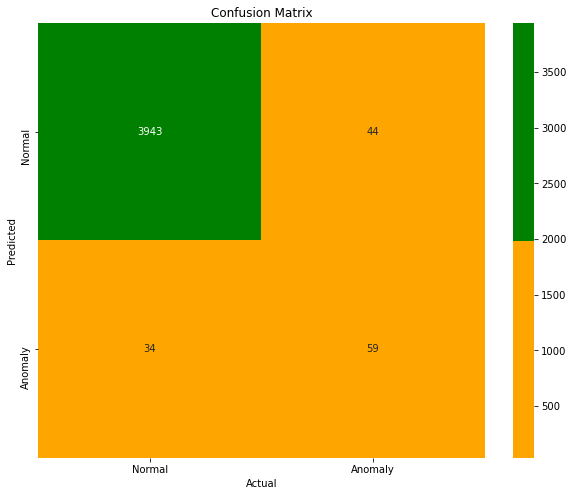

In [34]:
viz = Visulaization()
viz.draw_confusion_matrix(y_test, y_label)

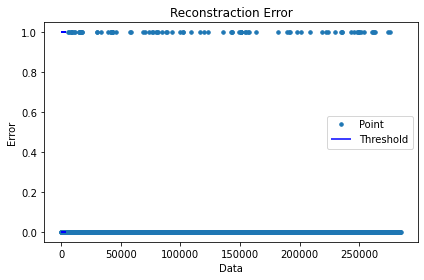

In [35]:
viz.draw_error(y_test, y_label)

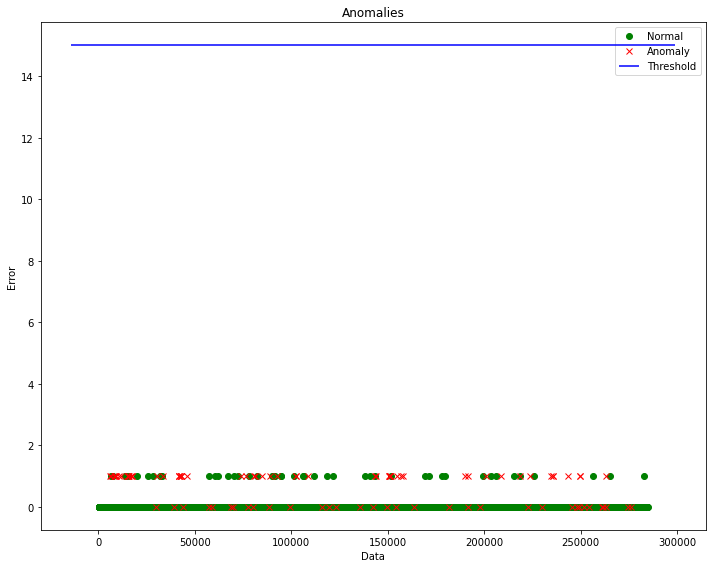

In [36]:
viz.draw_anomaly(y_test, y_label, threshold)